In [1]:
#Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
print('libaries imported')

libaries imported


In [2]:
#import the data set
df=pd.read_csv('cleaned_cars.csv')
print(f"our data set has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

our data set has 346689 rows and 10 columns


,price,price_log,year,age,manufacturer,model_reduced,odometer,fuel,title_status,transmission
0,33590,10.422013,2014,11,gmc,other,57923.0,gas,clean,other
1,22590,10.025307,2010,15,chevrolet,silverado 1500,71229.0,gas,clean,other
2,39590,10.586357,2020,5,chevrolet,silverado 1500 crew,19160.0,gas,clean,other
3,30990,10.341452,2017,8,toyota,tundra double cab sr,41124.0,gas,clean,other
4,15000,9.615872,2013,12,ford,f-150 xlt,128000.0,gas,clean,automatic


## I-Normalization of data (OneHotEncoder, StandardScaler)

In [3]:
# Defining my features
X=df.drop(['price','price_log'], axis=1)
y=df['price_log']

#Spliting the data set into train and test set
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

#Selecting the features
numeric_features=X.select_dtypes(include='number').columns.to_list()
categorical_features = X.select_dtypes(include='object').columns.tolist()

#Transorming the data
preprocessor=ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numeric_features),
        ('cat',OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

#Apply on training and test set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed=preprocessor.transform(X_test)

## II- Base models

### 1-Linear regression

running the model
predictions on train and test set
Metrics of the model
parameters of the model
coefficients of the model
hypothesis of the model


2025/06/28 06:06:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/28 06:06:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


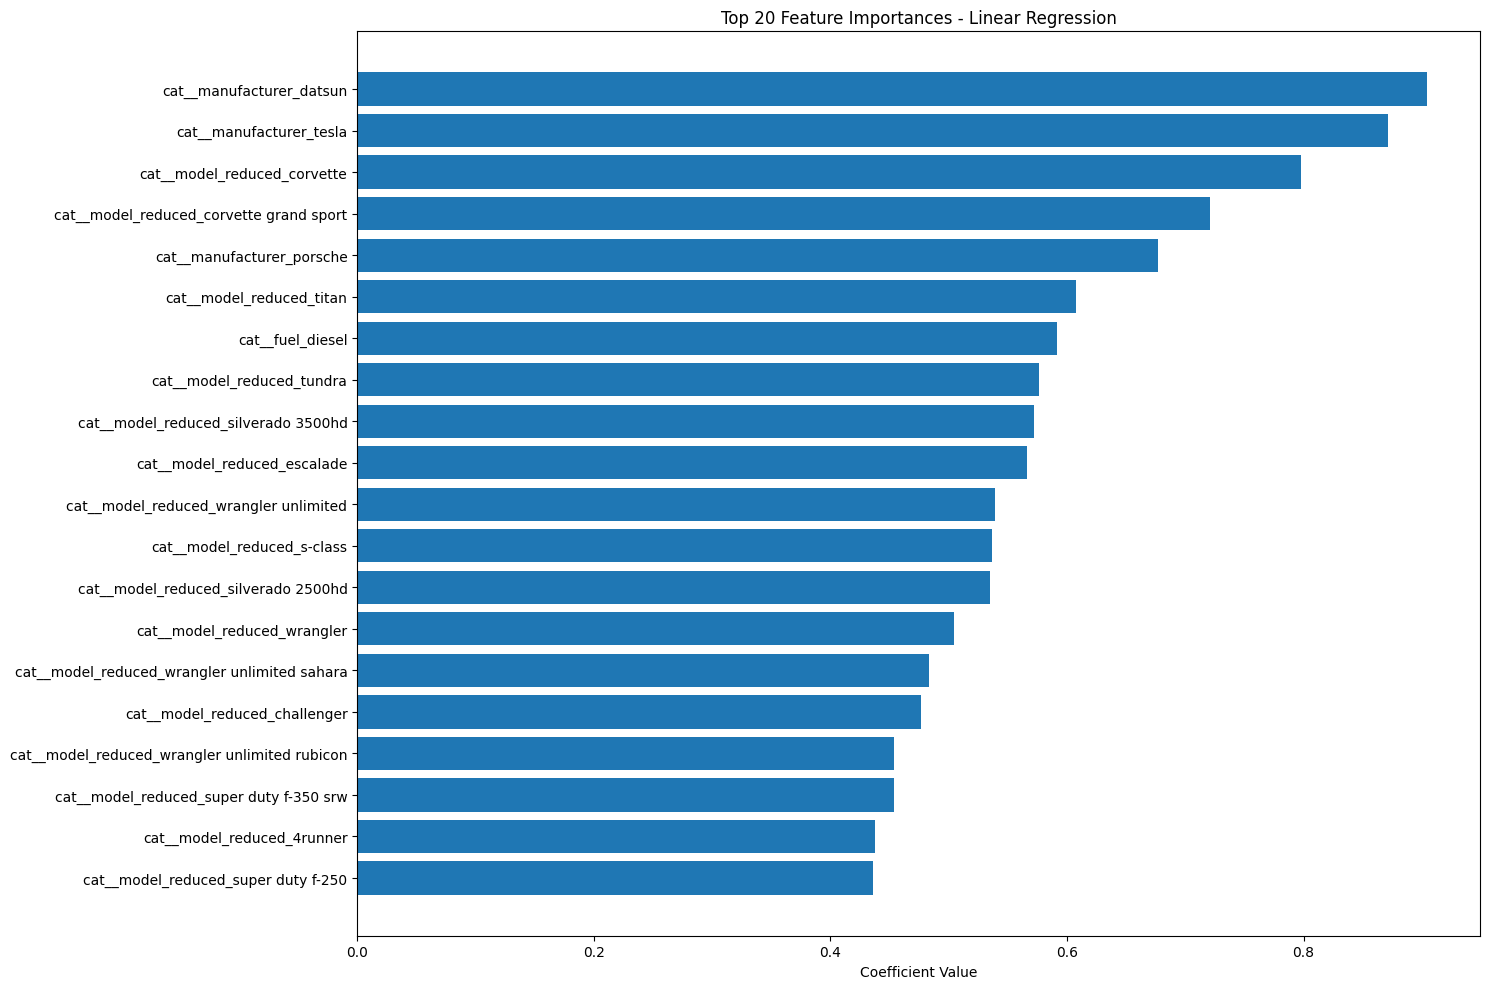

In [4]:
import tempfile

mlflow.set_experiment('based models')
with mlflow.start_run(run_name='linear regression'):
    # 1-Run the model
    print("running the model")
    lr=LinearRegression()
    lr.fit(X_train_processed, y_train)
    
    # 2-predictions on train and test set
    print('predictions on train and test set')
    y_train_pred_lr=lr.predict(X_train_processed)
    y_test_pred_lr=lr.predict(X_test_processed)
    
    # 3- Metrics
    print('Metrics of the model')
    r2_score_train_lr=r2_score(y_train, y_train_pred_lr)
    r2_score_test_lr=r2_score(y_test, y_test_pred_lr)
    mae_train_lr=mean_absolute_error(y_train, y_train_pred_lr)
    mae_test_lr=mean_absolute_error(y_test,y_test_pred_lr)
    mse_train_lr=mean_squared_error(y_train, y_train_pred_lr)
    mse_test_lr=mean_squared_error(y_test, y_test_pred_lr)
    
    # 4- Log the metrics
    mlflow.log_metric("r2_train", r2_score_train_lr)
    mlflow.log_metric("r2_test", r2_score_test_lr)
    mlflow.log_metric("mae_train", mae_train_lr)
    mlflow.log_metric("mae_test", mae_test_lr)
    mlflow.log_metric("mse_train", mse_train_lr)
    mlflow.log_metric("mse_test", mse_test_lr)
    
    # 5-Log Parameters
    print('parameters of the model')
    mlflow.log_params(lr.get_params())
    mlflow.set_tag("model_type", "Linear Regression")
    
    # 6-Coefficients of the model
    print('coefficients of the model')
    feature_names = preprocessor.get_feature_names_out()
    intercept=lr.intercept_
    coefficients = lr.coef_
    coef_df = pd.DataFrame({'intercept':intercept, 'feature': feature_names, 'coefficient': coefficients})
    coef_df = coef_df.sort_values('coefficient', ascending=False)
    # Save and log the coeff 
    os.makedirs("artifacts", exist_ok=True)
    coef_df.to_csv("artifacts/coefficients.csv", index=False)
    mlflow.log_artifact("artifacts/coefficients.csv", "coefficients")
    
    #plot the top 20 best features
    plt.figure(figsize=(15, 10))
    top_20_features = coef_df.head(20)
    plt.barh(top_20_features['feature'], top_20_features['coefficient'])
    plt.title('Top 20 Feature Importances - Linear Regression')
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("artifacts/coefficients_plot.png")
    mlflow.log_artifact("artifacts/coefficients_plot.png", "coefficients_plot")

    # 7-Assumptions of the model
    print('hypothesis of the model')
    residuals = y_test - y_test_pred_lr
    with tempfile.TemporaryDirectory() as tmpdir:
        # PLOT 1: Résiduals vs. Predicted values (for Linearity et Homoscedasticity)
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test_pred_lr, y=residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs. Predicted Values')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plot_path_1 = os.path.join(tmpdir, "residuals_vs_predicted.png")
        plt.savefig(plot_path_1)
        plt.close()
        mlflow.log_artifact(plot_path_1, "diagnostic_plots")
        # PLOT 2: Q-Q Plot ( Normality of residuals)
        plt.figure(figsize=(10, 6))
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot of Residuals')
        plot_path_2 = os.path.join(tmpdir, "qq_plot.png")
        plt.savefig(plot_path_2)
        plt.close()
        mlflow.log_artifact(plot_path_2, "diagnostic_plots")


    # Model log
    mlflow.sklearn.log_model(lr, "lr_model_base")
    

### 2- Ridge Regression

In [5]:
import tempfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import mlflow

# Ridge model using mlflow
mlflow.set_experiment('based models')
with mlflow.start_run(run_name='Ridge'):
    #1-Running the model
    print('--- Training Ridge model ---')
    ridge = Ridge(random_state=42)
    ridge.fit(X_train_processed, y_train)

    #2-predictions of the model on train and test set
    print('Making predictions...')
    y_train_pred_ri = ridge.predict(X_train_processed)
    y_test_pred_ri = ridge.predict(X_test_processed)

    #3-Metrics of the ridge model
    print('Evaluating metrics...')
    r2_train_ri = r2_score(y_train, y_train_pred_ri)
    r2_test_ri = r2_score(y_test, y_test_pred_ri)
    mse_train_ri = mean_squared_error(y_train, y_train_pred_ri)
    # CORRIGÉ: Faute de frappe
    mse_test_ri = mean_squared_error(y_test, y_test_pred_ri) 
    mae_train_ri = mean_absolute_error(y_train, y_train_pred_ri)
    mae_test_ri = mean_absolute_error(y_test, y_test_pred_ri)
    
    #Performance table
    table_ridge = pd.DataFrame({
        'Metrics': ['R2', 'MSE', 'MAE'],
        'Train set': [r2_train_ri, mse_train_ri, mae_train_ri],
        'Test set': [r2_test_ri, mse_test_ri, mae_test_ri]
    })
    print("\nPerformance Table:")
    print(table_ridge)

    #4- Log the metrics
    print('Logging metrics to MLflow...')
    mlflow.log_metric('R2_train', r2_train_ri)
    mlflow.log_metric('R2_test', r2_test_ri)
    mlflow.log_metric('MSE_train', mse_train_ri)
    mlflow.log_metric('MSE_test', mse_test_ri)
    mlflow.log_metric('MAE_train', mae_train_ri)
    mlflow.log_metric('MAE_test', mae_test_ri)
    mlflow.log_metric('intercept', ridge.intercept_)

    #5-Log parameters
    print('Logging parameters...')
    mlflow.log_params(ridge.get_params())
    mlflow.set_tag("model_type", "Ridge")

    #6- Coefficients
    print("Logging coefficients artifacts...")
    features_name = preprocessor.get_feature_names_out()
    coef_ri = ridge.coef_
    features_table = pd.DataFrame({
        'Feature': features_name,
        'Coefficient': coef_ri
    })
    features_table = features_table.sort_values(by='Coefficient', ascending=False)
    
    with tempfile.TemporaryDirectory() as tmpdir:
        # Save and log the coefficient table
        coef_csv_path = os.path.join(tmpdir, "coefficients.csv")
        features_table.to_csv(coef_csv_path, index=False)
        mlflow.log_artifact(coef_csv_path, "coefficients")

        # Plot the top 20 best features
        plt.figure(figsize=(15, 10))
        top_20_features_ri = features_table.head(20)
        plt.barh(top_20_features_ri['Feature'], top_20_features_ri['Coefficient'])
        plt.title('Top 20 Feature Importances - Ridge Regression')
        plt.xlabel('Coefficient Value')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        coef_plot_path = os.path.join(tmpdir, "ridge_coefficients_plot.png")
        plt.savefig(coef_plot_path)
        plt.close()
        mlflow.log_artifact(coef_plot_path, "ridge_coefficients_plot")

    # Model log
    print("Logging the model...")
    # CORRIGÉ: Log du bon modèle
    mlflow.sklearn.log_model(ridge, "model")

print("--- Ridge run completed successfully! ---")

--- Training Ridge model ---
Making predictions...
Evaluating metrics...

Performance Table:
  Metrics  Train set  Test set
0      R2   0.713180  0.710240
1     MSE   0.196882  0.198362
2     MAE   0.301576  0.301599
Logging metrics to MLflow...
Logging parameters...
Logging coefficients artifacts...


2025/06/28 06:06:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging the model...


2025/06/28 06:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Ridge run completed successfully! ---


### 3-Random forest

In [6]:
# Random forest Model training with mlflow
mlflow.set_experiment('based models')
with mlflow.start_run(run_name='random forest'):
    # 1-Running the model
    print('--- Training Random Forest ---')
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf.fit(X_train_processed, y_train)
    
    # 2-predictions on train and test set
    print('Making predictions...')
    y_train_predict_rf = rf.predict(X_train_processed)
    y_test_predict_rf = rf.predict(X_test_processed)

    # 3-Metrics of evaluation
    print("Evaluating metrics...")
    r2_train_rf = r2_score(y_train, y_train_predict_rf)
    r2_test_rf = r2_score(y_test, y_test_predict_rf)
    mse_train_rf = mean_squared_error(y_train, y_train_predict_rf)
    mse_test_rf = mean_squared_error(y_test, y_test_predict_rf)
    mae_train_rf = mean_absolute_error(y_train, y_train_predict_rf)
    mae_test_rf = mean_absolute_error(y_test, y_test_predict_rf)
    
    # Performance table
    performance_table_rf = pd.DataFrame({
        'Metrics': ['R²', 'MSE', 'MAE'],
        'Train Set': [r2_train_rf, mse_train_rf, mae_train_rf],
        'Test Set': [r2_test_rf, mse_test_rf, mae_test_rf] 
    })
    print("\nPerformance Table:")
    print(performance_table_rf) 
    
    # Log the metrics
    print("Logging metrics to MLflow...")
    mlflow.log_metric('r2_train', r2_train_rf)
    mlflow.log_metric('r2_test', r2_test_rf)
    mlflow.log_metric('mse_train', mse_train_rf)
    mlflow.log_metric('mse_test', mse_test_rf)
    mlflow.log_metric('mae_train', mae_train_rf)
    mlflow.log_metric('mae_test', mae_test_rf)
    
    # 4-log parameters
    print("Logging parameters...")
    mlflow.log_params(rf.get_params())
    mlflow.set_tag("model_type", "Random Forest")
    
    # 5-features importance and artefacts
    print("Logging artifacts (feature importances)...")
    
    importance = rf.feature_importances_
    features = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    with tempfile.TemporaryDirectory() as tmpdir:
        # Save and log the feature importance table
        features_csv_path = os.path.join(tmpdir, "feature_importances.csv")
        importance_df.to_csv(features_csv_path, index=False)
        mlflow.log_artifact(features_csv_path, "feature_importances")

        # Plot the 20 most important features
        plt.figure(figsize=(15, 10))
        top_20_features = importance_df.head(20)
        plt.barh(top_20_features['Feature'], top_20_features['Importance'])
        plt.title('Top 20 Feature Importances - Random Forest')
        plt.xlabel('Importance (Gini Impurity)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        features_plot_path = os.path.join(tmpdir, "feature_importances_plot.png")
        plt.savefig(features_plot_path)
        plt.close()
        mlflow.log_artifact(features_plot_path, "feature_importances_plot")

    # Log the model
    print("Logging the model...")
    mlflow.sklearn.log_model(rf, 'model')

print("--- Random Forest run completed successfully! ---")

--- Training Random Forest ---
Making predictions...
Evaluating metrics...

Performance Table:
  Metrics  Train Set  Test Set
0      R²   0.966486  0.828674
1     MSE   0.023005  0.117286
2     MAE   0.072938  0.177162
Logging metrics to MLflow...
Logging parameters...
Logging artifacts (feature importances)...


2025/06/28 06:55:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging the model...


2025/06/28 06:55:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Random Forest run completed successfully! ---


### 4-XGBOOST model

In [8]:
# XGBOOST Model training with mlflow

mlflow.set_experiment('based models')
with mlflow.start_run(run_name='XGBOOST'):
    # 1-Running the model
    print('--- XGBOOST Regressor ---')
    xgb = XGBRegressor(random_state=42, n_jobs=-1)
    xgb.fit(X_train_processed, y_train)
    
    # 2-predictions on train and test set
    print('Making predictions...')
    y_train_predict_xgb = xgb.predict(X_train_processed)
    y_test_predict_xgb = xgb.predict(X_test_processed)

    # 3-Metrics of evaluation
    print("Evaluating metrics...")
    r2_train_xgb = r2_score(y_train, y_train_predict_xgb)
    r2_test_xgb = r2_score(y_test, y_test_predict_xgb)
    mse_train_xgb = mean_squared_error(y_train, y_train_predict_xgb)
    mse_test_xgb = mean_squared_error(y_test, y_test_predict_xgb)
    mae_train_xgb = mean_absolute_error(y_train, y_train_predict_xgb)
    mae_test_xgb = mean_absolute_error(y_test, y_test_predict_xgb)
    
    # Performance table
    performance_table_xgb = pd.DataFrame({
        'Metrics': ['R²', 'MSE', 'MAE'],
        'Train Set': [r2_train_xgb, mse_train_xgb, mae_train_xgb],
        'Test Set': [r2_test_xgb, mse_test_xgb, mae_test_xgb] 
    })
    print("\nPerformance Table:")
    print(performance_table_xgb) 
    
    # Log the metrics
    print("Logging metrics to MLflow...")
    mlflow.log_metric('r2_train', r2_train_xgb)
    mlflow.log_metric('r2_test', r2_test_xgb)
    mlflow.log_metric('mse_train', mse_train_xgb)
    mlflow.log_metric('mse_test', mse_test_xgb)
    mlflow.log_metric('mae_train', mae_train_xgb)
    mlflow.log_metric('mae_test', mae_test_xgb)
    
    # 4-log parameters
    print("Logging parameters...")
    mlflow.log_params(xgb.get_params())
    mlflow.set_tag("model_type", "XGBRegressor")
    
    # 5-features importance and artefacts
    print("Logging artifacts (feature importances)...")
    
    importance_xgb = xgb.feature_importances_
    features_xgb = preprocessor.get_feature_names_out()
    importance_df_xgb = pd.DataFrame({'Feature': features_xgb, 'Importance': importance_xgb})
    importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)
    
    with tempfile.TemporaryDirectory() as tmpdir:
        # Save and log the feature importance table
        features_csv_path = os.path.join(tmpdir, "importance_df_xgb.csv")
        importance_df_xgb.to_csv(features_csv_path, index=False)
        mlflow.log_artifact(features_csv_path, "importance_df_xgb")

        # Plot the 20 most important features
        plt.figure(figsize=(15, 10))
        top_20_features_xgb = importance_df_xgb.head(20)
        plt.barh(top_20_features_xgb['Feature'], top_20_features_xgb['Importance'])
        plt.title('Top 20 Feature Importances - XGBOOST Regressor')
        plt.xlabel('Feature Importance (F-score)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        features_plot_path = os.path.join(tmpdir, "feature_importances_plot_xgb.png")
        plt.savefig(features_plot_path)
        plt.close() 
        mlflow.log_artifact(features_plot_path, "feature_importances_plot_xgb")

    # Log the model
    print("Logging the model...")
    mlflow.sklearn.log_model(xgb, 'model')

print("--- XGBOOST Regressor run completed successfully! ---")

--- XGBOOST Regressor ---
Making predictions...
Evaluating metrics...

Performance Table:
  Metrics  Train Set  Test Set
0      R²   0.780596  0.771113
1     MSE   0.150606  0.156690
2     MAE   0.263077  0.267069
Logging metrics to MLflow...
Logging parameters...
Logging artifacts (feature importances)...


2025/06/28 07:49:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging the model...


2025/06/28 07:49:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- XGBOOST Regressor run completed successfully! ---


## III- Optimized models with RandomizedCV

### 1-XGBOOST optmized model

In [10]:
from sklearn.model_selection import RandomizedSearchCV

mlflow.set_experiment('optimized models')
with mlflow.start_run(run_name='XGBOOST_optimized'):
    #1- Parameters of optimization
    print('Pameters of optimization')
    param_distributions={
        'n_estimators':[100,200,300],
        'max_depth':[2,4,6,7],
        'learning_rate': [0.01, 0.1,1],
        'min_child_weight': [1, 3, 5]
    }

    #2- Using RandomizedSearchCV for the search
    print('\n2- Find best hyperparameters ...\n')
    xgb_best=XGBRegressor(random_state=42, n_jobs=-1)
    grid_search_xgb=RandomizedSearchCV(estimator=xgb_best, param_distributions=param_distributions, cv=5, n_jobs=-1, verbose=1)
    grid_search_xgb.fit(X_train_processed, y_train)

    #log the best parameters
    print("best parameters found : ", grid_search_xgb.best_params_)
    mlflow.log_params(grid_search_xgb.best_params_)

    #3- Take back the best XGBOOST model
    print('\n3- Training the best XGBOOST model...\n')
    best_model = grid_search_xgb.best_estimator_

    #4- predictions on train and test set
    print('predictions on train and test set')
    y_train_pred_xgb = best_model.predict(X_train_processed)
    y_test_pred_xgb = best_model.predict(X_test_processed)

    #5- Metrics of performance
    print('Metrics of performance')
    metrics_train = {
        'r2_train': r2_score(y_train, y_train_pred_xgb),
        'mse_train': mean_squared_error(y_train, y_train_pred_xgb),
        'mae_train': mean_absolute_error(y_train, y_train_pred_xgb)
    }
    metrics_test = {
        'r2_test': r2_score(y_test, y_test_pred_xgb),
        'mse_test': mean_squared_error(y_test, y_test_pred_xgb),
        'mae_test': mean_absolute_error(y_test, y_test_pred_xgb)
    }
    # Log the cross validation score
    cv_score = {'r2_cross_validated': grid_search_xgb.best_score_}
    print(f"Score R2 of cross validation : {cv_score['r2_cross_validated']:.4f}")

    # Table of performance
    perf_table = pd.DataFrame({
        'Metric': ['R2', 'MSE', 'MAE'],
        'Train': [metrics_train['r2_train'], metrics_train['mse_train'], metrics_train['mae_train']],
        'Test': [metrics_test['r2_test'], metrics_test['mse_test'], metrics_test['mae_test']]
    })
    print(perf_table)

    # 6- Log metrics on mlflow
    print('\n6- Log metrics on mlflow...\n')
    mlflow.log_metrics(metrics_train)
    mlflow.log_metrics(metrics_test)
    mlflow.log_metrics(cv_score)

    # 7- Features importance
    print('\n7- Features importance...\n')
    importance = best_model.feature_importances_
    features = preprocessor.get_feature_names_out()
    importance_df_xgb = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

    # logg artifacts
    with tempfile.TemporaryDirectory() as tmpdir:
        
        artifact_subdir = "feature_importance"
        
        # Save the features importance table
        features_csv_path = os.path.join(tmpdir, "feature_importances_xgb.csv")
        importance_df_xgb.to_csv(features_csv_path, index=False)
        mlflow.log_artifact(features_csv_path, artifact_path=artifact_subdir)

        # plot and save the graph
        plt.figure(figsize=(15, 10))
        top_20_features_xgb = importance_df_xgb.head(20)
        plt.barh(top_20_features_xgb['Feature'], top_20_features_xgb['Importance'])
        plt.title('Top 20 Feature Importances - XGBOOST Optimized')
        
        plt.xlabel('Importance (weight)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        features_plot_path = os.path.join(tmpdir, "feature_importances_plot_xgb.png")
        plt.savefig(features_plot_path)
        plt.close()
        mlflow.log_artifact(features_plot_path, artifact_path=artifact_subdir)

    # 8- Log the model
    print("\n8- Logging model on MLflow...\n")
    mlflow.sklearn.log_model(best_model, "model")

print("\n XGBOOST runned successfully !")
    
    

2025/06/29 00:36:33 INFO mlflow.tracking.fluent: Experiment with name 'optimized models' does not exist. Creating a new experiment.


Pameters of optimization

2- Find best hyperparameters ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best parameters found :  {'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 1}

3- Training the best XGBOOST model...

predictions on train and test set
Metrics of performance
Score R2 of cross validation : 0.7895
  Metric     Train      Test
0     R2  0.821547  0.790628
1    MSE  0.122496  0.143331
2    MAE  0.230261  0.245773

6- Log metrics on mlflow...


7- Features importance...



2025/06/29 00:37:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



8- Logging model on MLflow...



2025/06/29 00:37:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



 XGBOOST runned successfully !


### 2- Random Forest optimized model

In [4]:
import tempfile

In [5]:
mlflow.set_experiment('optimized models')
with mlflow.start_run(run_name="Random_Forest_Optimized"):

    # 1- Best hyper parameters
    print('\n1- Search Best hyper parameters\n')
    param_distributions = {
    'n_estimators': [50, 100, 150, 200], 
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
    }

    # 2- Using RandomizedSearchCV for the search
    print('\n2- Find best hyperparameters ...\n')
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, scoring='r2', cv=3, n_iter=10, random_state=42)
    grid_search.fit(X_train_processed, y_train)
    
    # Log the best parameters
    print("best parameters found : ", grid_search.best_params_)
    mlflow.log_params(grid_search.best_params_)

    # 3- Take back the best model
    print('\n3- Training the best random forest model...\n')
    best_model = grid_search.best_estimator_

    # 4- Predictions on train and test set
    print('\n4- Predictions on train and test set...\n')
    y_train_pred = best_model.predict(X_train_processed)
    y_test_pred = best_model.predict(X_test_processed)

    # 5- Metrics evaluation
    print('\n5- Metrics evaluation...\n')
    metrics_train = {
        'r2_train': r2_score(y_train, y_train_pred),
        'mse_train': mean_squared_error(y_train, y_train_pred),
        'mae_train': mean_absolute_error(y_train, y_train_pred)
    }
    metrics_test = {
        'r2_test': r2_score(y_test, y_test_pred),
        'mse_test': mean_squared_error(y_test, y_test_pred),
        'mae_test': mean_absolute_error(y_test, y_test_pred)
    }
    
    # Log the cross validation score
    cv_score = {'r2_cross_validated': grid_search.best_score_}
    print(f"Score R2 of cross validation : {cv_score['r2_cross_validated']:.4f}")

    # Table of performance
    perf_table = pd.DataFrame({
        'Metric': ['R2', 'MSE', 'MAE'],
        'Train': [metrics_train['r2_train'], metrics_train['mse_train'], metrics_train['mae_train']],
        'Test': [metrics_test['r2_test'], metrics_test['mse_test'], metrics_test['mae_test']]
    })
    print(perf_table)

    # 6- Log metrics on mlflow
    print('\n6- Log metrics on mlflow...\n')
    mlflow.log_metrics(metrics_train)
    mlflow.log_metrics(metrics_test)
    mlflow.log_metrics(cv_score)

    # 7- Features importance
    print('\n7- Features importance...\n')
    importance = best_model.feature_importances_
    features = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # log artifacts
    with tempfile.TemporaryDirectory() as tmpdir:
        
        artifact_subdir = "feature_importance"
        
        # Save the features importance table
        features_csv_path = os.path.join(tmpdir, "feature_importances.csv")
        importance_df.to_csv(features_csv_path, index=False)
        mlflow.log_artifact(features_csv_path, artifact_path=artifact_subdir)

        # plot and save the graph
        plt.figure(figsize=(15, 10))
        top_20_features = importance_df.head(20)
        plt.barh(top_20_features['Feature'], top_20_features['Importance'])
        plt.title('Top 20 Feature Importances - Random Forest Optimized')
        
        plt.xlabel('Importance (Mean Decrease in Impurity)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        features_plot_path = os.path.join(tmpdir, "feature_importances_plot.png")
        plt.savefig(features_plot_path)
        plt.close()
        mlflow.log_artifact(features_plot_path, artifact_path=artifact_subdir)

    # 8- Log the model
    print("\n8- Logging modele on MLflow...\n")
    mlflow.sklearn.log_model(best_model, "model")

print("\nRandom forest runned successfully !")


1- Search Best hyper parameters


2- Find best hyperparameters ...

best parameters found :  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}

3- Training the best random forest model...


4- Predictions on train and test set...


5- Metrics evaluation...

Score R2 of cross validation : 0.8196
  Metric     Train      Test
0     R2  0.925147  0.830554
1    MSE  0.051382  0.115998
2    MAE  0.128321  0.192230

6- Log metrics on mlflow...


7- Features importance...



2025/06/29 18:17:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



8- Logging modele on MLflow...



2025/06/29 18:17:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Random forest runned successfully !
